# Applications of Quantum Machine Learning in Marketing
Bachelorthesis by Maximilian Priessnitz<br>
June 2024 - Vienna, Austria<br>
Content: This notebook shows the practical part of the bachelor thesis, which optimizes the classic support vector classifier (and its kernel variations) and tests it against the optimized quantum support vector classifier.

### Extra Installation

In [4]:
# %pip install qiskit qiskit-machine-learning
# %pip install pydantic==1.7.2

## Data Preparation
The data preparation aims to find the best features (based on the time quantum simulation restrictions) and clean the data.<br>
For this thesis the "Telco" dataset gives the best practical showcase.<br>
I use 200 rows because of time issues during the quantum simulation.

In [28]:
import pandas as pd

file_path = 'Quantum Marketing/telco.csv'

org_df = pd.read_csv(file_path)

df = org_df.sample(n=200, random_state=123)
# df = org_df

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
941,0811-GSDTP,Female,0,No,Yes,13,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,30.15,382.2,No
1404,1970-KKFWL,Female,0,No,No,35,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.30,797.1,No
5515,2892-GESUL,Female,0,Yes,Yes,18,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,309.25,No


In [29]:
first_row = df.iloc[0]

for column in df.columns:
    dtype = df[column].dtype
    example_value = first_row[column]
    print(f"{column} ({dtype}): {example_value}")

customerID (object): 0811-GSDTP
gender (object): Female
SeniorCitizen (int64): 0
Partner (object): No
Dependents (object): Yes
tenure (int64): 13
PhoneService (object): No
MultipleLines (object): No phone service
InternetService (object): DSL
OnlineSecurity (object): No
OnlineBackup (object): Yes
DeviceProtection (object): No
TechSupport (object): No
StreamingTV (object): No
StreamingMovies (object): No
Contract (object): Month-to-month
PaperlessBilling (object): No
PaymentMethod (object): Electronic check
MonthlyCharges (float64): 30.15
TotalCharges (object): 382.2
Churn (object): No


In [30]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Make a copy of the original DataFrame
df_processed = df.copy()

# Drop CustomerID column
df_processed.drop(columns=['customerID'], inplace=True)

# Convert TotalCharges to numeric and handle missing values
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].mean(), inplace=True)

# Encode categorical variables
encoder = LabelEncoder()
categorical_cols = df_processed.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df_processed[col] = encoder.fit_transform(df_processed[col])

# Ensure all columns are of numeric data types
df_processed = df_processed.astype('float64')

# Now df_processed is ready for machine learning
df_processed.head(3)

/var/folders/64/zkcqc27x1p3cgq_28fymy7700000gn/T/ipykernel_68568/2284113817.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].mean(), inplace=True)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
941,0.0,0.0,0.0,1.0,13.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,30.15,382.20,0.0
1404,0.0,0.0,0.0,0.0,35.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,23.30,797.10,0.0
5515,0.0,0.0,1.0,1.0,18.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,3.0,19.35,309.25,0.0


In [31]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the data
df_scaled = scaler.fit_transform(df_processed)
df_scaled = pd.DataFrame(df_scaled, columns=df_processed.columns)
df_scaled.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,-1.0,-0.5,-1.0,1.509533,-0.835459,-3.391165,0.073175,-1.138508,-1.015635,1.077391,-0.967116,-0.976624,-1.143673,-1.202993,-0.904534,-1.116777,0.434970,-1.172430,-0.852447,-0.608164
1,-1.0,-0.5,-1.0,-0.662457,0.040618,0.294884,1.118535,1.524669,0.125528,-0.056705,0.184213,0.172345,-0.011323,-0.068094,1.507557,-1.116777,-1.456204,-1.399880,-0.676036,-0.608164
2,-1.0,-0.5,1.0,1.509533,-0.636351,0.294884,-0.972184,1.524669,0.125528,-0.056705,0.184213,0.172345,-0.011323,-0.068094,1.507557,-1.116777,1.380557,-1.531037,-0.883465,-0.608164


In [32]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

# Initialize SVM classifier
svc = SVC(kernel="linear")

# RFE model
rfe = RFE(estimator=svc, n_features_to_select=6)
rfe.fit(df_scaled, df_processed['Churn'])

# Get the ranking of the features
feature_ranking = rfe.ranking_
selected_features = df_scaled.columns[rfe.support_]

# Print selected features
print("Selected features:", selected_features)

Selected features: Index(['Dependents', 'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')


In [33]:
import numpy as np
from sklearn.model_selection import train_test_split

churn_array = np.array(df_processed['Churn'])

# Splitting the data into training and testing sets with 80% training data and 20% testing data
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(df_scaled[selected_features], churn_array, test_size=0.20, random_state=42)

# Splitting the data into training and testing sets with 70% training data and 30% testing data
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(df_scaled[selected_features], churn_array, test_size=0.30, random_state=42)

## Finding the perfect Parameters
After the scaling and selecting the reduced amount of features, I continue the analysis with a grid search for hyperparameter tuning with 2 different splits.<br>
At first a 80:20 split for the traning and test data, and in the second round a 70:30 split.

### SVC

#### Folds

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time

svc = SVC(probability=True)

# Set up the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10, 100]
}

# Define scorers
roc_auc_scorer = make_scorer(roc_auc_score, needs_threshold=True)
precision_scorer = make_scorer(precision_score, zero_division=0)

scoring = {
    'accuracy': 'accuracy',
    'precision': precision_scorer,
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': roc_auc_scorer
}


##### 80 - 20

In [35]:
# Initialize the GridSearchCV object with stratified k-fold
grid_search_8020 = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
start_time = time.time()
grid_search_8020.fit(X_train_80, y_train_80)
end_time = time.time()
training_time_8020 = end_time - start_time

Fitting 5 folds for each of 126 candidates, totalling 630 fits


In [36]:
# Best parameters and best ROC-AUC score
print("Best parameters found:", grid_search_8020.best_params_)
print("Best accuracy score with cross-validation:", grid_search_8020.best_score_)

# Evaluate all metrics for the best model
best_model = grid_search_8020.best_estimator_

# Measure the time taken for prediction
start_time = time.time()
y_pred = best_model.predict(X_test_20)
end_time = time.time()
time_taken_8020_pred = end_time - start_time

print(f"Time taken for training (80-20 split): {training_time_8020:.4f} seconds")
print(f"Time taken for prediction (80-20 split): {time_taken_8020_pred:.4f} seconds")
print("Accuracy:", accuracy_score(y_test_20, y_pred))
print("Precision:", precision_score(y_test_20, y_pred, zero_division=0))
print("Recall:", recall_score(y_test_20, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test_20, y_pred, zero_division=0))
print("ROC AUC Score:", roc_auc_score(y_test_20, best_model.predict_proba(X_test_20)[:, 1]))


Best parameters found: {'C': 0.001, 'gamma': 10, 'kernel': 'poly'}
Best accuracy score with cross-validation: 1.0
Time taken for training (80-20 split): 2.3578 seconds
Time taken for prediction (80-20 split): 0.0008 seconds
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0


##### 70 - 30

In [37]:
# Compute class weights for the 70:30 split
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_70), y=y_train_70)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

svc = SVC(probability=True, class_weight=class_weights_dict)

# Initialize the GridSearchCV object with stratified k-fold
grid_search_7030 = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)


# Fit the grid search
start_time = time.time()
grid_search_7030.fit(X_train_70, y_train_70)
end_time = time.time()
training_time_7030 = end_time - start_time


Fitting 5 folds for each of 126 candidates, totalling 630 fits


In [38]:
# Best parameters and best ROC-AUC score
print("Best parameters found:", grid_search_7030.best_params_)
print("Best accuracy score with cross-validation:", grid_search_7030.best_score_)

# Evaluate all metrics for the best model
best_model = grid_search_7030.best_estimator_

# Measure the time taken for prediction
start_time = time.time()
y_pred = best_model.predict(X_test_30)
end_time = time.time()
time_taken_7030_pred = end_time - start_time

print(f"Time taken for training (70-30 split): {training_time_7030:.4f} seconds")
print(f"Time taken for prediction (70-30 split): {time_taken_7030_pred:.4f} seconds")
print("Accuracy:", accuracy_score(y_test_30, y_pred))
print("Precision:", precision_score(y_test_30, y_pred, zero_division=0))
print("Recall:", recall_score(y_test_30, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test_30, y_pred, zero_division=0))
print("ROC AUC Score:", roc_auc_score(y_test_30, best_model.predict_proba(X_test_30)[:, 1]))


Best parameters found: {'C': 0.001, 'gamma': 1, 'kernel': 'poly'}
Best accuracy score with cross-validation: 1.0
Time taken for training (70-30 split): 0.3886 seconds
Time taken for prediction (70-30 split): 0.0011 seconds
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0


### QSVC

#### Feature Map

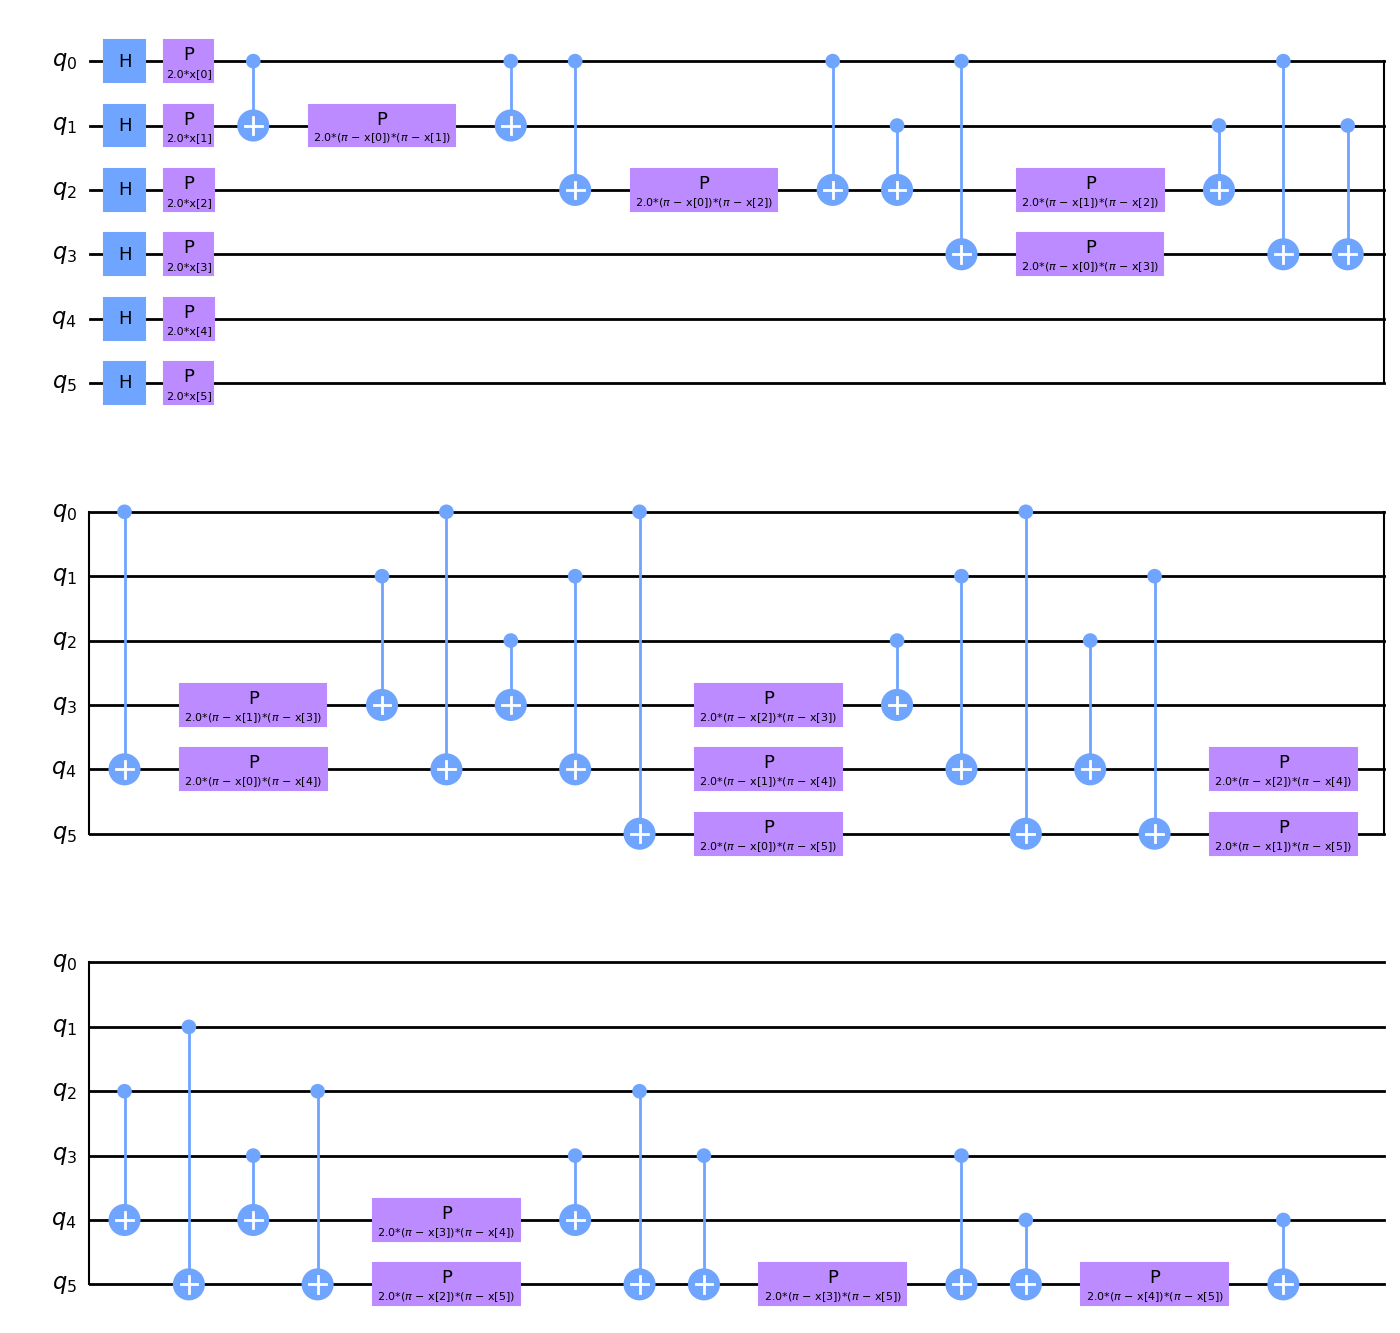

In [17]:
from qiskit.circuit.library import ZZFeatureMap

num_features = df_scaled[selected_features].shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

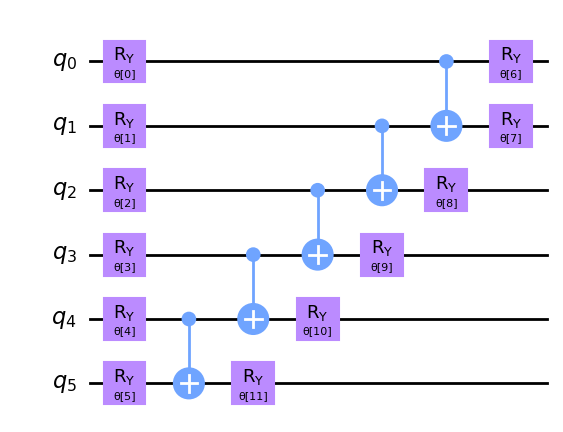

In [18]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=1)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

#### Folds

In [39]:
import numpy as np
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
import time
from tqdm import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin

class QSVCWithProgress(QSVC):
    def fit(self, X, y, **fit_params):
        with tqdm(total=len(self.param_grid['C']) * len(self.param_grid['gamma']) * self.cv) as pbar:
            for params in tqdm(self.param_grid):
                self.set_params(**params)
                super().fit(X, y, **fit_params)
                pbar.update(1)
        return self

# Quantum kernel with ZZFeatureMap and FidelityQuantumKernel
feature_map = ZZFeatureMap(feature_dimension=X_train_80.shape[1], reps=1)
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map)

# Quantum SVM with the quantum kernel
qsvc = QSVC(quantum_kernel=quantum_kernel)

# Set up the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10, 100]
}

# Define scorers
roc_auc_scorer = make_scorer(roc_auc_score, needs_threshold=True)
precision_scorer = make_scorer(precision_score, zero_division=0)

scoring = {
    'accuracy': 'accuracy',
    'precision': precision_scorer,
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': roc_auc_scorer
}


##### 80-20

In [40]:
# Initialize the GridSearchCV object with stratified k-fold and progress bar
grid_search_8020 = GridSearchCV(
    estimator=qsvc,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

# Measure the time taken to fit the grid search
start_time = time.time()
grid_search_8020.fit(X_train_80, y_train_80)
end_time = time.time()
training_time_8020 = end_time - start_time

# Best parameters and best ROC-AUC score
print("Best parameters found (80-20 split):", grid_search_8020.best_params_)
print("Best accuracy score with cross-validation (80-20 split):", grid_search_8020.best_score_)

# Evaluate all metrics for the best model
best_model_8020 = grid_search_8020.best_estimator_

# Measure the time taken for prediction
start_time = time.time()
y_pred = best_model_8020.predict(X_test_20)
end_time = time.time()
prediction_time_8020 = end_time - start_time

# Calculate metrics
accuracy_8020 = accuracy_score(y_test_20, y_pred)
precision_8020 = precision_score(y_test_20, y_pred, zero_division=0)
recall_8020 = recall_score(y_test_20, y_pred, zero_division=0)
f1_8020 = f1_score(y_test_20, y_pred, zero_division=0)
roc_auc_8020 = roc_auc_score(y_test_20, best_model_8020.decision_function(X_test_20))

# Output results
print(f"Quantum SVM Training Time (80-20 split): {training_time_8020:.4f} seconds")
print(f"Quantum SVM Prediction Time (80-20 split): {prediction_time_8020:.4f} seconds")
print(f"Quantum SVM Accuracy (80-20 split): {accuracy_8020:.4f}")
print(f"Quantum SVM Precision (80-20 split): {precision_8020:.4f}")
print(f"Quantum SVM Recall (80-20 split): {recall_8020:.4f}")
print(f"Quantum SVM F1 Score (80-20 split): {f1_8020:.4f}")
print(f"Quantum SVM ROC AUC Score (80-20 split): {roc_auc_8020:.4f}")

Fitting 5 folds for each of 42 candidates, totalling 210 fits


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found (80-20 split): {'C': 10, 'gamma': 'scale'}
Best accuracy score with cross-validation (80-20 split): 0.86875
Quantum SVM Training Time (80-20 split): 1623.0952 seconds
Quantum SVM Prediction Time (80-20 split): 20.6533 seconds
Quantum SVM Accuracy (80-20 split): 0.7250
Quantum SVM Precision (80-20 split): 1.0000
Quantum SVM Recall (80-20 split): 0.3529
Quantum SVM F1 Score (80-20 split): 0.5217
Quantum SVM ROC AUC Score (80-20 split): 0.9668


##### 70-30

In [41]:
# Initialize the GridSearchCV object with stratified k-fold and progress bar
grid_search_7030 = GridSearchCV(
    estimator=qsvc,
    param_grid=param_grid,
    scoring=scoring,
    refit='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=1,
    n_jobs=-1
)

# Measure the time taken to fit the grid search
start_time = time.time()
grid_search_7030.fit(X_train_70, y_train_70)
end_time = time.time()
training_time_7030 = end_time - start_time

# Best parameters and best ROC-AUC score
print("Best parameters found (70-30 split):", grid_search_7030.best_params_)
print("Best accuracy score with cross-validation (70-30 split):", grid_search_7030.best_score_)

# Evaluate all metrics for the best model
best_model_7030 = grid_search_7030.best_estimator_

# Measure the time taken for prediction
start_time = time.time()
y_pred = best_model_7030.predict(X_test_30)
end_time = time.time()
prediction_time_7030 = end_time - start_time

# Calculate metrics
accuracy_7030 = accuracy_score(y_test_30, y_pred)
precision_7030 = precision_score(y_test_30, y_pred, zero_division=0)
recall_7030 = recall_score(y_test_30, y_pred, zero_division=0)
f1_7030 = f1_score(y_test_30, y_pred, zero_division=0)
roc_auc_7030 = roc_auc_score(y_test_30, best_model_7030.decision_function(X_test_30))

# Output results
print(f"Quantum SVM Training Time (70-30 split): {training_time_7030:.4f} seconds")
print(f"Quantum SVM Prediction Time (70-30 split): {prediction_time_7030:.4f} seconds")
print(f"Quantum SVM Accuracy (70-30 split): {accuracy_7030:.4f}")
print(f"Quantum SVM Precision (70-30 split): {precision_7030:.4f}")
print(f"Quantum SVM Recall (70-30 split): {recall_7030:.4f}")
print(f"Quantum SVM F1 Score (70-30 split): {f1_7030:.4f}")
print(f"Quantum SVM ROC AUC Score (70-30 split): {roc_auc_7030:.4f}")

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best parameters found (70-30 split): {'C': 10, 'gamma': 'scale'}
Best accuracy score with cross-validation (70-30 split): 0.8571428571428571
Quantum SVM Training Time (70-30 split): 1082.6290 seconds
Quantum SVM Prediction Time (70-30 split): 26.3725 seconds
Quantum SVM Accuracy (70-30 split): 0.7500
Quantum SVM Precision (70-30 split): 1.0000
Quantum SVM Recall (70-30 split): 0.3182
Quantum SVM F1 Score (70-30 split): 0.4828
Quantum SVM ROC AUC Score (70-30 split): 0.9617
